# Generalized Lasso Problem

In this project, we study the generalized lasso problem, and more specifically, the fused lasso problem and implement efficient algorithms for achieving an optimal solution.

The generalized lasso problem is defined in <cite data-cite="Tibs16">(Arnold et. al., 2016)</cite> as:

$$\min_{\beta} f(\beta) + \lambda ||D \beta ||_1 $$

where the objective $ f\left(\beta\right) = \frac{1}{2}||y - \beta||_2^2$ is strongly convex and smooth, $y \in \mathbf{R}^n$ is the input, $D \in \mathbf{R}^{m \times n}$ is a matrix which penalizes large changes with respect to the temporal or spatial structure forcing the coefficients to vary smoothly and $\lambda \ge 0$  is a regularization parameter. When $D = I$ the problem can be interpreted as the usual lasso problem.

We are going to specifically look at the fused lasso variant introduced in <cite data-cite="Tibs05">(Tibshirani et. al., 2005)</cite>. The fused lasso problem is a special case of the generalized lasso, defined as:

$$ ||D\beta||_1 = \sum ^{n-1} _{i = 1} |\beta_i - \beta_{i+1}| $$

for the 1D case. It is evident that this formulation generates sparsity not in the solution (like the usual lasso), but in the adjacent differences, i.e., it encourages adjacent members of the solution vector to be equal to each other. 

The fused lasso can be used for total variation denoising in 1D. Additionally, the fused lasso can be defined for total variation denoising over a graph, $G = (V, E)$, and is defined as:

$$ ||D\beta||_1 = \sum _{(i,j) \in E} |\beta_i - \beta_{j}| $$

which encourages the solution to have equal components across any $(i,j) \in E$. This can be especially useful for denoising images which can be represented as a 2D grid graph.

## 1-D Case (Total Variation Denoising and Linear Trend Filtering)

The first part of the project covers the simple 1-D (adjacency in only one dimension) case of the fused lasso, also called the total variation denoising in 1D. We have chosen the loss function to be the gaussian loss function, 

$$ f(\beta) = \frac{1}{2}\sum ^{n} _{i = 1} (y_i - \beta_{i})^2 $$

where $y_i$ are the points given in the data set. The matrix $D$ for the fused lasso problem can be defined as:

$$ D = \begin{bmatrix}
-1 & 1 & 0 & \cdots & 0 & 0 \\
0 & -1 & 1 & \cdots & 0 & 0 \\
\vdots \\
0 & 0 & 0 & \cdots & -1 & 1
\end{bmatrix}$$

so that $ ||D\beta||_1 = \sum _{(i,j) \in E} |\beta_i - \beta_{j}| $. This penalty function, as mentioned earlier, generates sparsity in adjacent differences.

Similarly, higher order fits are also possible. For example, a piecewise linear solution for $\beta$ is generated if the matrix $D$ is defined as:

$$ D = \begin{bmatrix}
1 & -2 & 1 & \cdots & 0 & 0 \\
0 & 1 & -2 & \cdots & 0 & 0 \\
\vdots \\
0 & 0 & 0 & \cdots & -2 & 1
\end{bmatrix}$$

#### Primal Subgradient Method

Subgradient algorithm can be used for the primal problem. We compute the subgradient of the cost function with respect to $\beta$ and set it to zero. The subgradient of the cost function is given as:

$$ g = \nabla f(\beta) + \lambda D^T \phi$$

where $\phi \in \partial || D \beta|| _1$. This can be expanded and written as:

$$ g = \beta - y + \lambda D^T \cdot sign(D\beta)$$

where $sign(D\beta)_i = 0$ when $(D\beta)_i = 0$. This approach works for any general $D$, and can be used for both the TV denoising and Trend Filtering cases in 1D, as well as the 2D graph case.

In [1]:
# Importing packages
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse import linalg as spla
from time import time

In [2]:
# Generate 1D data with 4 different regimes. Each regime has a mean and variance.
def data(size):
    y = np.zeros((size,1))
    y[0:size/5] = 20*rn.random((size/5,1)) + 50
    y[size/5:3*size/5] = 15*rn.random((2*size/5,1)) + 30
    y[3*size/5:4*size/5] = 20*rn.random((size/5,1)) + 60
    y[4*size/5:size] = 10*rn.random((size/5,1)) + 90
    return y

# Penalty Matrix for TV Denoising
def denoisingMat(size):
    zeros = np.zeros([size-1, 1]); I = np.eye(size-1)
    add = np.hstack((zeros,I))
    sub = np.hstack((-I,zeros))
    D = add + sub
    return D

# Penalty Matrix for Linear Trend Filtering
def trendFilteringLinearMat(size):
    zeros1 = np.zeros([size-2, 1]); zeros2 = np.zeros([size-2, 2])
    I = np.eye(size-2)
    
    add1  = np.hstack((zeros2,I))
    sub   = np.hstack((zeros1, np.hstack((-2*I,zeros1))))
    add2  = np.hstack((I,zeros2))
    D = add1 + sub + add2
    return D

In [3]:
# Generalized Lasso Penalty
def costFunc(y, beta, D, lam):
    fVal = 0.5*la.norm(y - beta)**2 + lam*la.norm(np.dot(D,beta),ord = 1)
    return fVal

# Subgradient Descent for Lasso with diminishing step size
def subgradient(y, beta, D, t, lam, c=1e-1):
    step_size = c/(np.sqrt(t+1))
    obj_grad  = beta - y
    penalty_subgrad = lam*np.dot(D.T,np.sign(np.dot(D,beta)))
    delF = obj_grad + penalty_subgrad 
    beta = beta - step_size*delF
    return beta

# Choose the data set size
size = 1000
y = data(size)

# Descent function for primal subgradient method
def descent(update, probType, y, reg, T=int(1e3)):
    size = y.shape[0]
    D = probType(size)
    beta = np.zeros((size,1))
    error = []
    l1 = []
    timeIter = []
    startTime = time()
    for t in xrange(T):
        beta = update(y, beta, D, t, reg)
        # record error and l1 norm
        if (t % 1 == 0) or (t == T - 1):
            error.append(la.norm(beta - y))
            l1.append(np.sum(np.abs(np.dot(D,beta))))
            timeIter.append(time()-startTime)
            assert not np.isnan(error[-1])

    return beta, error, l1, timeIter

In [4]:
# Solving for different values of regularization parameter
beta_sg10, error_sg10, l1_sg10, timeIter_sg10 = descent(subgradient, denoisingMat, y, reg=10)
beta_sg5, error_sg5, l1_sg5, timeIter_sg5 = descent(subgradient, denoisingMat, y, reg=5)
beta_sg20, error_sg20, l1_sg20, timeIter_sg20 = descent(subgradient, denoisingMat, y, reg=20)

beta_sg10LT, error_sg10LT, l1_sg10LT, timeIter_sg10LT = descent(subgradient, trendFilteringLinearMat, y, reg=10)
beta_sg5LT, error_sg5LT, l1_sg5LT, timeIter_sg5LT = descent(subgradient, trendFilteringLinearMat, y, reg=5)
beta_sg20LT, error_sg20LT, l1_sg20LT, timeIter_sg20LT = descent(subgradient, trendFilteringLinearMat, y, reg=20)

#### 1D denoising and Trend Filtering Results

We generate 1000 random data points with 4 different regimes. Where each regime is characterized by a different mean and unifromly distributed noise around the mean. Below we show the performance of Denoising and Trend Filtering algorithms for different values of the regularization parameter.

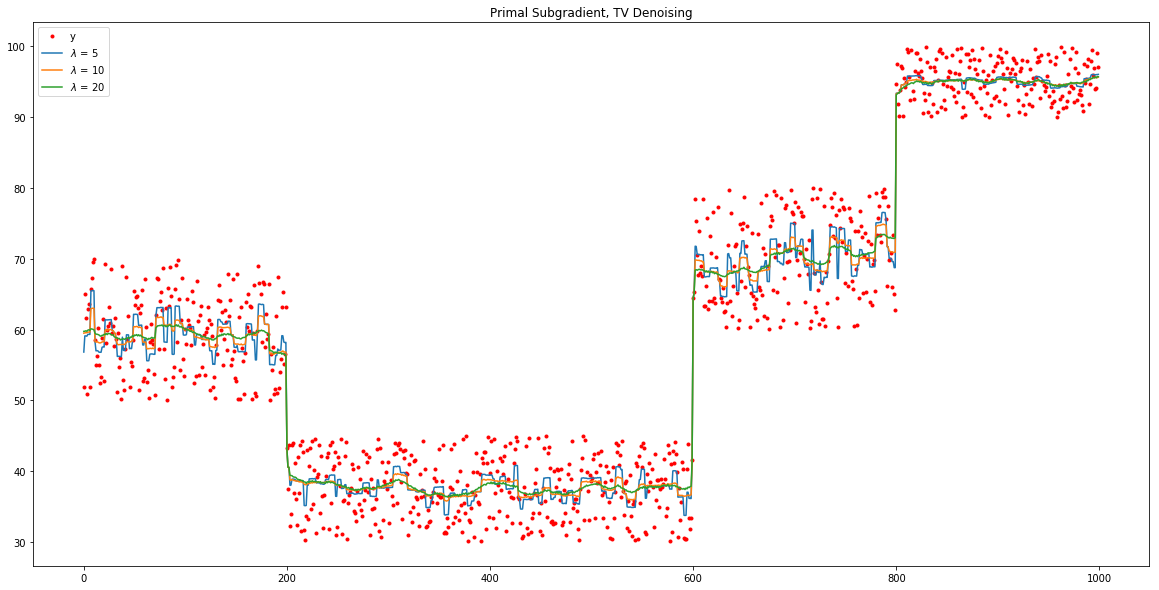

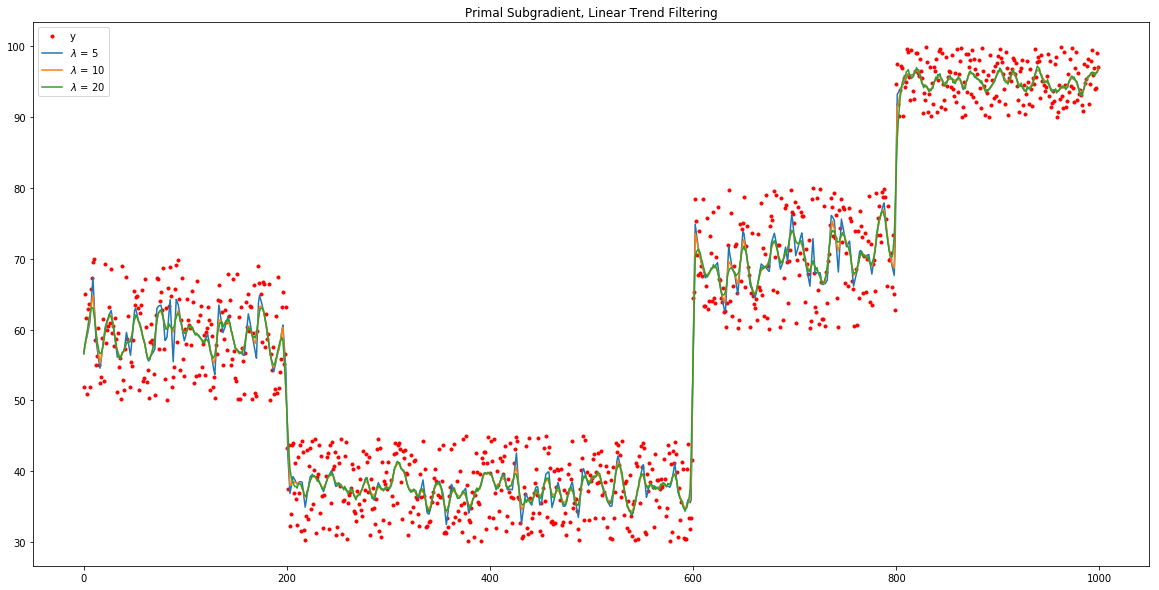

In [5]:
# Plotting
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(y, 'r.',label='y')
plt.plot(beta_sg5,label='$\lambda$ = 5')
plt.plot(beta_sg10,label='$\lambda$ = 10')
plt.plot(beta_sg20,label='$\lambda$ = 20')
plt.title('Primal Subgradient, TV Denoising')
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(20,10))
plt.plot(y, 'r.',label='y')
plt.plot(beta_sg5LT,label='$\lambda$ = 5')
plt.plot(beta_sg10LT,label='$\lambda$ = 10')
plt.plot(beta_sg20LT,label='$\lambda$ = 20')
plt.title('Primal Subgradient, Linear Trend Filtering')
plt.legend()
plt.show()

### Dual Proximal Gradient Method

The dual of the problem can be derived <cite data-cite="Tibs11">(Tibshirani et. al., 2011)</cite> by rewriting the problem as:

$$\min_{\beta, z} \frac{1}{2}||y - \beta||_2^2 + \lambda ||z ||_1, z = D\beta $$

Therefore, writing the Lagrangian, 

$$\mathcal{L}(\beta, z, u) = \frac{1}{2}||y - \beta||_2^2 + \lambda ||z ||_1 + u^T(D\beta - z)$$

and minimizing over $\beta, z$, we can derive the dual problem. Since the minimization over $\beta, z$ can be separated out, we can write the Lagrangian dual as:

$$ \min_{\beta} \left( \frac{1}{2}||y - \beta||_2^2 + u^TD\beta \right) = -\frac{1}{2}||y - D^Tu||_2^2 $$

and 

$$ \min_{z} \left(\lambda ||z||_1 - u^Tz \right) = \begin{cases} 0 & \text{if } ||u||_{\infty} \leq \lambda \\ -\infty & \text{otherwise} \end{cases} $$

Thus, the dual problem can be written as:

$$ \min_{u} = \frac{1}{2}||y - D^Tu||_2^2 \texttt{ subject to }  ||u||_{\infty} \leq \lambda $$ 

The primal problem is always strictly convex and has a unique solution, and is strictly feasible since it has no inequality constraints, thus strong duality holds. Therefore, the primal solution can be derived from the dual solution. This relationship can be derived by taking the partial derivative of the Lagrangian with respect to $\beta$ as follows:

$$ \frac{\partial \mathcal{L}}{\partial \beta} = 0 \implies \beta = y - D^Tu$$

The proximal descent algortihm can now be applied to the dual problem, since the prox operator on $u$ is just

$$ prox_c(u) = \arg\min_{z} \frac{1}{2c}||u - z||_2^2 \texttt{ subject to }  ||u||_{\infty} \leq \lambda$$

which is the projection onto the box $[-\lambda,\lambda]^m$ where $u \in \mathbf{R}^m$. Since this projection can be calculated easily, the dual proximal gradient method is fast and much cheaper than the proximal gradient algorithm on the primal problem.

In [6]:
def costFuncDualProx(y, v):
    fVal = 0.5*(np.dot(y.T,y) - np.dot((y+v).T,(y+v)))
    return fVal

def gradientDualProx(y, u, D, lam, c=1e-1):
    delFStar = -np.dot(D,(y - np.dot(D.T,u)))
    u = u - c*(delFStar)
    u[u > lam] = lam
    u[u < -lam] = -lam
    return u

def descentDualProx(update, probType, y, reg, T=int(1e3)):
    size = y.shape[0]
    D = probType(size)
    beta = np.zeros((size,1))
    u = np.zeros((D.shape[0],1))
    
    error = []
    l1 = []
    timeIter = []
    startTime = time()
    for t in xrange(T):
        u = update(y, u, D, reg)
        # record error and l1 norm
        if (t % 1 == 0) or (t == T - 1):
            beta = y - np.dot(D.T,u)
            error.append(la.norm(beta - y))
            l1.append(np.sum(np.abs(np.dot(D,beta))))
            timeIter.append(time()-startTime)
            assert not np.isnan(error[-1])

    return beta, error, l1, timeIter

In [7]:
beta_dpg5, error_dpg5, l1_dpg5, timeIter_dpg5 = descentDualProx(gradientDualProx, denoisingMat, y, reg=5)
beta_dpg10, error_dpg10, l1_dpg10, timeIter_dpg10 = descentDualProx(gradientDualProx, denoisingMat, y, reg=10)
beta_dpg20, error_dpg20, l1_dpg20, timeIter_dpg20 = descentDualProx(gradientDualProx, denoisingMat, y, reg=20)

beta_dpg5LT, error_dpg5LT, l1_dpg5LT, timeIter_dpg5LT = descentDualProx(gradientDualProx, trendFilteringLinearMat, y, reg=5)
beta_dpg10LT, error_dpg10LT, l1_dpg10LT, timeIter_dpg10LT = descentDualProx(gradientDualProx, trendFilteringLinearMat, y, reg=10)
beta_dpg20LT, error_dpg20LT, l1_dpg20LT, timeIter_dpg20LT = descentDualProx(gradientDualProx, trendFilteringLinearMat, y, reg=20)

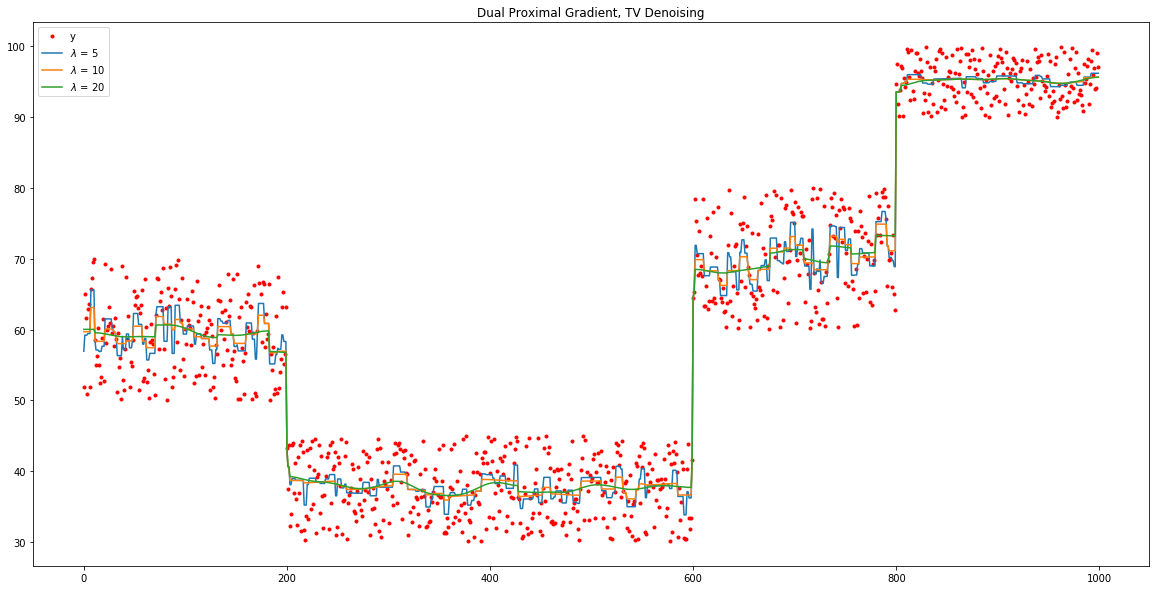

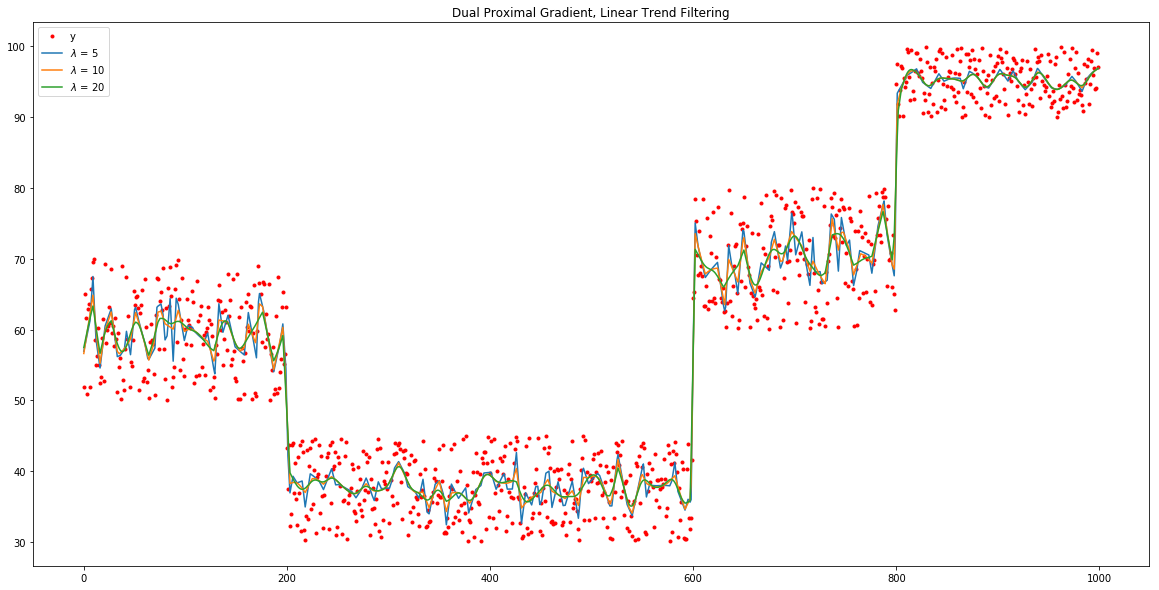

In [8]:
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(y, 'r.',label='y')
plt.plot(beta_dpg5,label='$\lambda$ = 5')
plt.plot(beta_dpg10,label='$\lambda$ = 10')
plt.plot(beta_dpg20,label='$\lambda$ = 20')
plt.title('Dual Proximal Gradient, TV Denoising')
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(20,10))
plt.plot(y, 'r.',label='y')
plt.plot(beta_dpg5LT,label='$\lambda$ = 5')
plt.plot(beta_dpg10LT,label='$\lambda$ = 10')
plt.plot(beta_dpg20LT,label='$\lambda$ = 20')
plt.title('Dual Proximal Gradient, Linear Trend Filtering')
plt.legend()
plt.show()

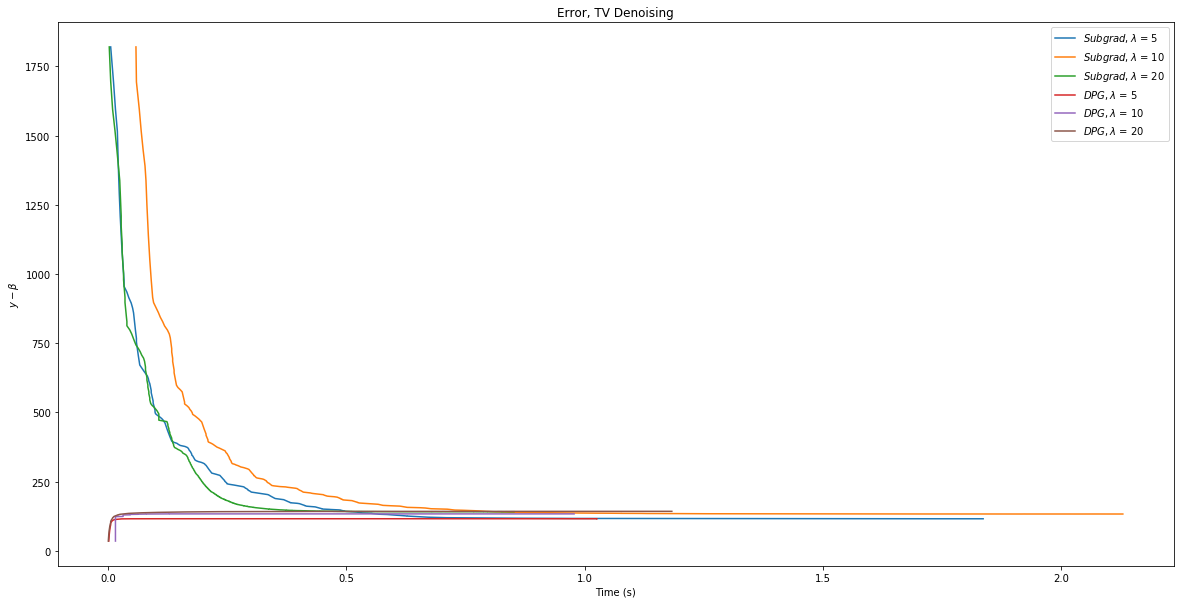

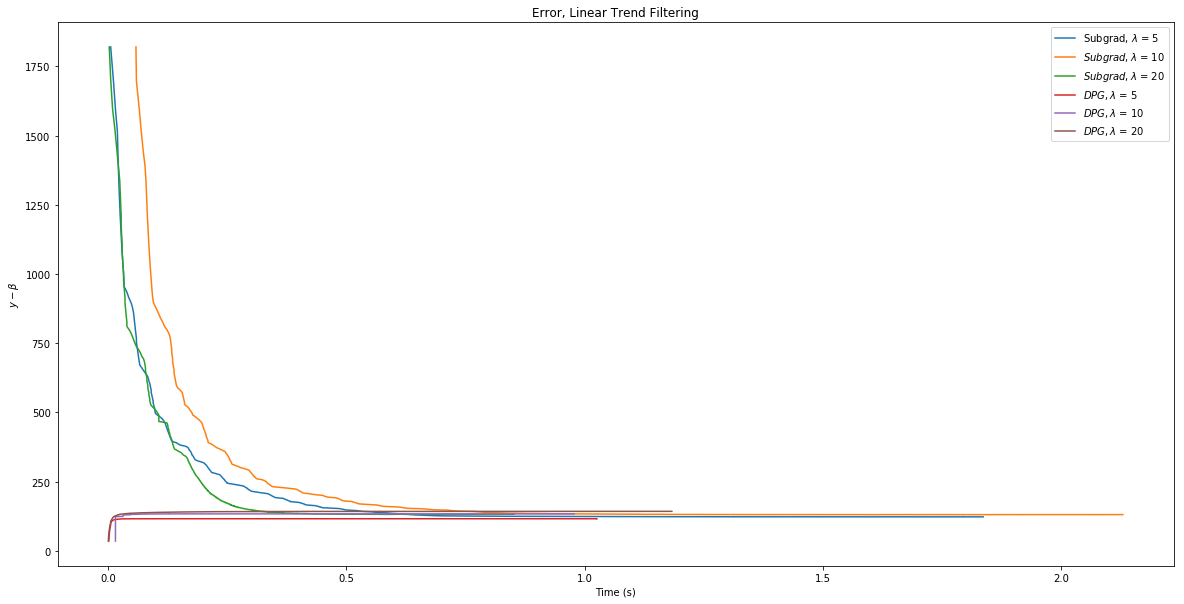

In [9]:
# Error Plotting
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(timeIter_sg5, error_sg5,label='$Subgrad, \lambda$ = 5')
plt.plot(timeIter_sg10, error_sg10,label='$Subgrad, \lambda$ = 10')
plt.plot(timeIter_sg20, error_sg20,label='$Subgrad, \lambda$ = 20')
plt.plot(timeIter_dpg5, error_dpg5,label='$DPG, \lambda$ = 5')
plt.plot(timeIter_dpg10, error_dpg10,label='$DPG, \lambda$ = 10')
plt.plot(timeIter_dpg20, error_dpg20,label='$DPG, \lambda$ = 20')
plt.title('Error, TV Denoising')
plt.xlabel('Time (s)')
plt.ylabel('$y - \\beta$')
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(20,10))
plt.plot(timeIter_sg5, error_sg5LT,label='Subgrad, $\lambda$ = 5')
plt.plot(timeIter_sg10, error_sg10LT,label='$Subgrad, \lambda$ = 10')
plt.plot(timeIter_sg20, error_sg20LT,label='$Subgrad, \lambda$ = 20')
plt.plot(timeIter_dpg5, error_dpg5,label='$DPG, \lambda$ = 5')
plt.plot(timeIter_dpg10, error_dpg10,label='$DPG, \lambda$ = 10')
plt.plot(timeIter_dpg20, error_dpg20,label='$DPG, \lambda$ = 20')
plt.title('Error, Linear Trend Filtering')
plt.xlabel('Time (s)')
plt.ylabel('$y - \\beta$')
plt.legend()
plt.show()

The dual proximal gradient method converges much faster than the primal subgradient method.

### Fast Dual Path Algorithm



In [86]:
def descentDualPath(y, reg):
    size = y.shape[0]
    D = denoisingMat(size)
    totalSet = np.arange(D.shape[0])
    x = spla.lsqr(D.T,y.flatten())
    u = x[0]
    uVec = np.expand_dims(u,1)
    beta = y - np.dot(D.T,uVec)
    lam = np.max(np.abs(u))
    iHit = np.argmax(np.abs(u))
    B = np.array([iHit])
    sgn = np.sign(u[iHit])
    s = np.array([sgn])
    counter = 0
    
    while lam > 0:
        counter = counter + 1
        
        BMinus = setExclusion(B, totalSet)
        if BMinus.size == 0:
            break
        
        DBMinus = D[BMinus,:]
        DB = D[B,:]
        x1 = spla.lsqr(DBMinus.T,y.flatten())
        x2 = spla.lsqr(DBMinus.T, np.dot(DB.T,np.expand_dims(s,1)))
        a = x1[0]
        b = x2[0]
        tHit, iHit = hittingCoordinate(a, b, BMinus, lam)

        lam = tHit
        u[BMinus] = a - lam*b
        u[B] = lam*s
        BOld = B.copy()
        B = np.append(B,iHit)
        sgn = np.sign(u[iHit])
        sOld = s.copy()
        s = np.append(s, sgn)
        
        print lam
        
        if lam < reg:
            u[BMinus] = a - reg*b
            u[BOld] = reg*sOld
            break
            
    u = np.expand_dims(u,1)
    beta = y - np.dot(D.T,u)   
    return beta    
        
def setExclusion(B, totalSet):
    mask = np.array([(i in B) for i in xrange(len(totalSet))])
    BMinus = totalSet[~mask]
    return BMinus

def hittingCoordinate(a, b, BMinus, lam):
    t = np.maximum((a/(b+1)),((a/(b-1))))
    t[t>lam] = np.minimum((a[t>lam]/(b[t>lam]+1)),((a[t>lam]/(b[t>lam]-1))))
    if t.size > 0:
        i = np.argmax(t)
        i = BMinus[i]
        t = np.max(t)
    else:
        t = 0
        i = 0
    return t, i

In [87]:
beta_dp = descentDualPath(y, reg=20)

6810.57862013
5599.1779466
5381.49987479


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in divide


4881.44432507
4718.03587268
2278.72083927
378.41463608
266.005004505
246.545977923
222.151171132
177.680217987
153.080205444
100.665309106
85.0743604923
77.4052575953
56.505690178
45.1018954271
44.4643490959
44.2084440026
42.6354213331
40.7339125738
39.0004873124
36.871427781
32.8936001511
28.9396754167
27.3543764462
27.2538534219
25.843214094
25.6563294763
25.1368729721
24.0003617329
21.0983736723
20.6951068464
19.6429241088


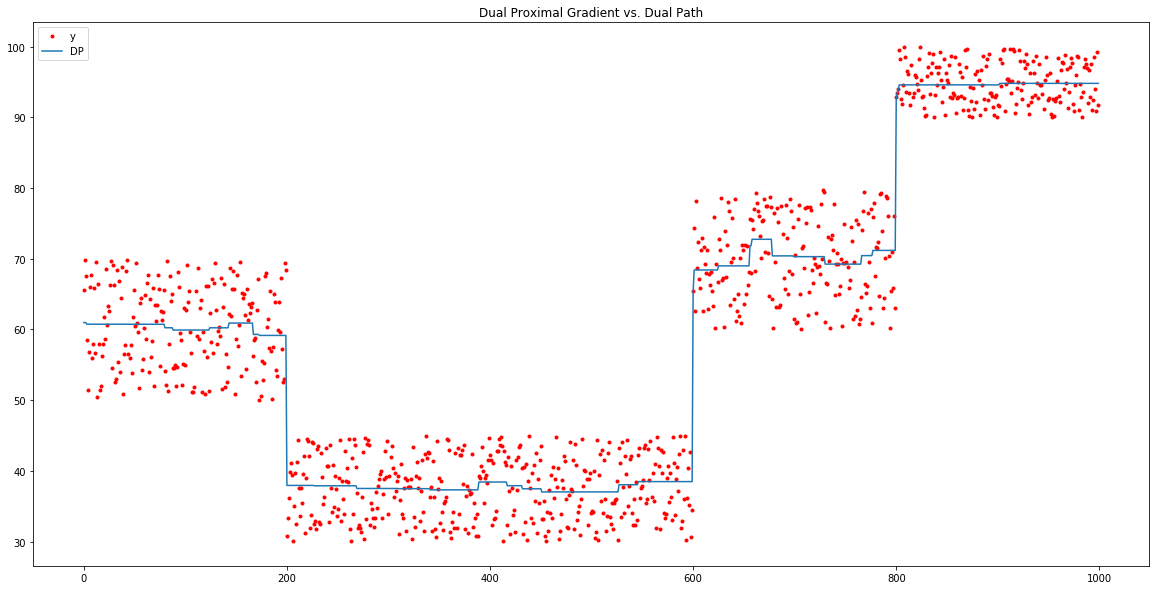

In [93]:
plt.clf()
plt.figure(figsize=(20,10))
plt.plot(y, 'r.',label='y')
# plt.plot(beta_sg10,label='$Subgrad, \lambda$ = 20')
# plt.plot(beta_dpg20,label='$DPG, \lambda$ = 20')
plt.plot(beta_dp,label='DP')
plt.title('Dual Proximal Gradient vs. Dual Path')
plt.legend()
plt.show()

## Graph (Total Variation Denoising)

### Primal Subgradient Method

In [16]:
# Load image

from PIL import Image
import matplotlib.image as mpimg

# orig_img = Image.open('data/randompic_2.png').convert('L')
# orig_img.save('data/randompic_2_greyscale.png')
# corr_img = Image.open('data/randompic_corrupted.png').convert('L')
# corr_img.save('data/randompic_greyscale_corrupted.png')

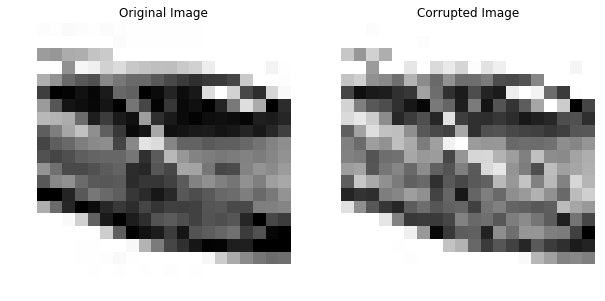

In [270]:
def loadImage():
    # Convert to arrays.
    orig_img = Image.open("data/randompic_2_greyscale.png")
#     orig_img = Image.open("data/lena.png")

    np.random.seed(1)
    p = 0.05

    Uorig = np.array(orig_img)
#     Uorig = np.zeros((10,10))
#     orig_img = Image.fromarray(np.uint8(Uorig))
    row, col = Uorig.shape

    Known = np.ones((row, col))
    for i in xrange(row):
        for j in xrange(col):
            if np.random.random() > (1-p):
                Known[i, j] = 0
    
    Ucorr = Uorig + 70*rn.random((row, col))
    Ucorr[Ucorr > 255] = 255
    Ucorr[Ucorr < 0] = 0
    corr_img = Image.fromarray(np.uint8(Ucorr))
    corr_img.save('data/randompic_2_greyscale_corrupted.png')
#     corr_img.save('data/lena_corrupted.png')
    return Ucorr, corr_img, orig_img

Ucorr, corr_img, orig_img = loadImage()

%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
print ax
ax[0].imshow(np.asarray(orig_img),cmap='gray');
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

In [271]:
def denoisingMat2DGrid(size):
    add = np.eye(size)
    sub = -np.eye(size)
    D = np.concatenate((add,sub),axis = 1)
    return D

def denoisingMatGraph(row, col):
    D1 = np.zeros(((row)*(col-1),row*col))
    D2 = np.zeros(((row-1)*(col),row*col))
    DSegmentRow = denoisingMat(col)
    DSegmentCol = denoisingMat2DGrid(col)
    for i in range(row):
        startRow = i*(col-1)
        endRow = (i+1)*(col-1)
        startCol = i*(col)
        endCol = (i+1)*(col)
        D1[startRow:endRow,startCol:endCol] = DSegmentRow
    for i in range(row-1):
        startRow = i*(col)
        endRow = (i+1)*(col)
        startCol = i*(col)
        endCol = (i+2)*(col)
        D2[startRow:endRow,startCol:endCol] = DSegmentCol
    D = np.concatenate((D1, D2), axis = 0)
    return D

def denoisingMatGraphSparse(row,col):
    D1 = sp.csr_matrix(((row)*(col-1),row*col))
    D2 = sp.csr_matrix(((row-1)*(col),row*col))
    DSegmentRow = sp.csr_matrix(denoisingMat(col))
    DSegmentCol = sp.csr_matrix(denoisingMat2DGrid(col))
    for i in range(row):
        startRow = i*(col-1)
        endRow = (i+1)*(col-1)
        startCol = i*(col)
        endCol = (i+1)*(col)
        D1[startRow:endRow,startCol:endCol] = DSegmentRow
    for i in range(row-1):
        startRow = i*(col)
        endRow = (i+1)*(col)
        startCol = i*(col)
        endCol = (i+2)*(col)
        D2[startRow:endRow,startCol:endCol] = DSegmentCol
    D = sp.vstack([D1, D2])
    return D

def subgradientGraph(y, beta, D, t, lam, c=1e-1):
    betaSp = sp.csr_matrix(beta)
    ySp = sp.csr_matrix(y)
    delF1 = betaSp - ySp
    dotProd1 = D.dot(betaSp)
    dotProd1[dotProd1 > 0] = 1
    dotProd1[dotProd1 < 0] = -1
    delF2 = D.T.dot(dotProd1)*lam
    delF = delF1 + delF2
    betaSp = betaSp - c/(np.sqrt(t+1))*(delF)
    beta = betaSp.toarray()
    return beta

In [272]:
def descentGraph(update, Ucorr, reg, T=int(2e3)):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
    D = denoisingMatGraphSparse(row, col)
    beta = np.zeros((y.shape[0],1))
    error = []
    l1 = []
    for t in xrange(T):
        beta = update(y, beta, D, t, reg)
        betaSp = sp.csr_matrix(beta)
        # record error and l1 norm
        if (t % 100 == 0) or (t == T - 1):
            error.append(la.norm(beta - y))
            l1.append(np.sum(np.abs(D.dot(betaSp).toarray())))
            assert not np.isnan(error[-1])
    
    beta = np.reshape(beta, (row, col))
    return Ucorr, beta, error, l1

In [277]:
Ucorr, beta_sg_graph, error_sg_graph, l1_sg_graph = descentGraph(subgradientGraph, Ucorr, reg=20)

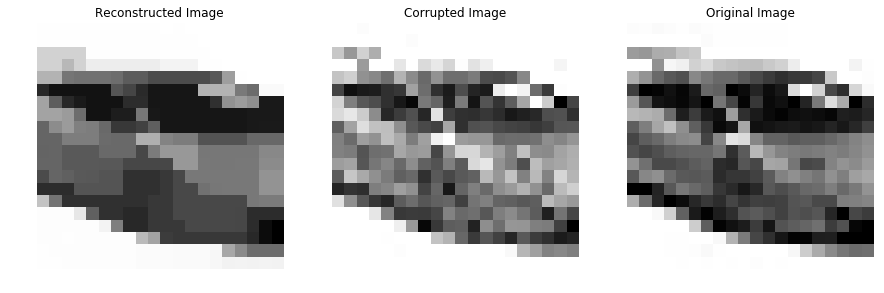

In [278]:
reconstruct_img = Image.fromarray(np.uint8(beta_sg_graph))

%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img),cmap='gray');
ax[0].set_title("Reconstructed Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(np.asarray(orig_img),cmap='gray');
ax[2].set_title("Original Image")
ax[2].axis('off');

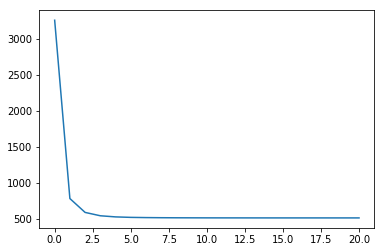

In [279]:
plt.plot(error_sg_graph)

### Dual Proximal Gradient Method

In [280]:
def gradientDualProxSparse(y, u, D, lam, c=1e-1):
    uSp = sp.csr_matrix(u)
    ySp = sp.csr_matrix(y)
    dotProd1 = D.T.dot(uSp)
    sum1 = ySp - dotProd1
    delFStar = -D.dot(sum1)
    uSp = uSp - c*(delFStar)
    uSp[uSp > lam] = lam
    uSp[uSp < -lam] = -lam
    u = uSp.toarray()
    return u

def costFuncDualProxSparse(y, v):
    vSp = sp.csr_matrix(v)
    ySp = sp.csr_matrix(y)
    dotProd1 = ySp.T.dot(ySp)
    dotProd2 = (ySp+vSp).T.dot((ySp+vSp))
    fVal = 0.5*(dotProd1 - dotProd2).toarray()
    return fVal

In [281]:
def descentDualProxGraph(update, Ucorr, reg, T=int(2e3)):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
    D = denoisingMatGraphSparse(row, col)
#     D = trendFilteringLinearMat(size)
    u = np.zeros((D.shape[0],1))
    
    error = []
    l1 = []
    for t in xrange(T):
        u = update(y, u, D, reg)
        # record error and l1 norm
        if (t % 100 == 0) or (t == T - 1):
            uSp = sp.csr_matrix(u)
            ySp = sp.csr_matrix(y)
            vSp = -D.T.dot(uSp)
            v = vSp.toarray()
            betaSp = ySp + vSp 
            error.append(costFuncDualProxSparse(y, v))
            l1.append(np.sum(np.abs(D.dot(betaSp).toarray())))
            assert not np.isnan(error[-1])
    
    beta = betaSp.toarray()
    beta = np.reshape(beta, (row, col))
    return beta, error, l1

In [284]:
beta_dpg_graph, error_dpg_graph, l1_dpg_graph = descentDualProxGraph(gradientDualProxSparse, Ucorr, reg=20)

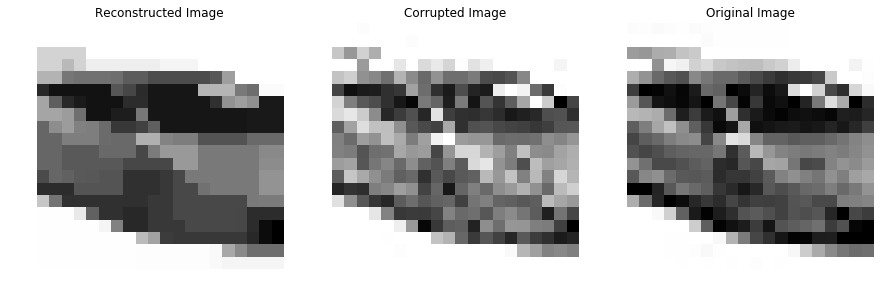

In [285]:
reconstruct_img_dpg = Image.fromarray(np.uint8(beta_dpg_graph))

%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img_dpg),cmap='gray');
ax[0].set_title("Reconstructed Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(np.asarray(orig_img),cmap='gray');
ax[2].set_title("Original Image")
ax[2].axis('off');

### Fast Dual Path Algorithm

In [301]:
def descentDualPathGraph(Ucorr, reg):
    row, col = Ucorr.shape
    y = np.reshape(Ucorr, (-1, 1))
#     print y.shape
    D = denoisingMatGraphSparse(row, col)
    totalSet = np.arange(D.shape[0])
#     print totalSet
#     print D.shape
    x = spla.lsqr(D.T,y.flatten())
#     print 'first'
    u = x[0]
#     print u
    uVec = np.expand_dims(u,1)
#     print uVec.shape
#     print np.dot(D.T,uVec).shape
    beta = y - D.T.dot(uVec)
    lam = np.max(np.abs(u))
    iHit = np.argmax(np.abs(u))
    B = np.array([iHit])
    sgn = np.sign(u[iHit])
    s = np.array([sgn])
    counter = 0
    flag = 0
    leavingCoord = 0
    
    while lam > 0:
        print '\n'
        print 'counter= ', counter
#         print 'flag= ', flag
        counter = counter + 1
        BMinus = setExclusion(B, totalSet)
        B = np.sort(B)
        if BMinus.size == 0:
            break
        DBMinus = D[BMinus,:]
        DB = D[B,:]
        x1 = spla.lsqr(DBMinus.T,y.flatten())
        x2 = spla.lsqr(DBMinus.T, DB.T.dot(np.expand_dims(s,1)))
        a = x1[0]
        b = x2[0]
        u[BMinus] = a - lam*b
        u[B] = lam*s
#         print 'a= ', a
#         print 'b= ', b
#         print 's= ', s
        tLeave, iLeave = leavingCoordinate(a, b, DB, DBMinus, y, s, B)
        tHit, iHit = hittingCoordinateGraph(a, b, BMinus, lam, flag, leavingCoord)
#         print 'tHit= ', tHit
#         print 'iHit= ', iHit
        if tHit>tLeave:
            lam = tHit
            BOld = B.copy()
            B = np.append(B,iHit)
            sgn = np.sign(u[iHit])
            sOld = s.copy()
            s = np.append(s, sgn)
            flag = 0
        else:
            lam = tLeave
            BOld = B.copy()
            sOld = s.copy()
            leavingCoord = B[iLeave]
#             print 'Leaving Coordinate= ', leavingCoord
            B = np.delete(B,iLeave,0)
            s = np.delete(s,iLeave,0)
            flag = 1
        print 'lam=', lam 
        print 'B Shape=', B.shape
        if lam < reg:
            u[BMinus] = a - reg*b
            u[BOld] = reg*sOld
            break
    u = np.expand_dims(u,1)
    beta = y - D.T.dot(u)
    beta = np.reshape(beta, (row, col))
    return beta    

def setExclusion(B, totalSet):
    mask = np.array([(i in B) for i in xrange(len(totalSet))])
    BMinus = totalSet[~mask]
    return BMinus

def hittingCoordinateGraph(a, b, BMinus, lam, flag, leavingCoord):
    t = np.maximum((a/(b+1)),((a/(b-1))))
    t[t>lam] = np.minimum((a[t>lam]/(b[t>lam]+1)),((a[t>lam]/(b[t>lam]-1))))
    if t.size > 0:
#         print 'BMinus= ', BMinus
        i = np.argmax(t)
        iMax = BMinus[i]
        tMax = np.max(t)
        print 'i= ', i
        print a[i]
        print b[i]
        print (a[i]/(b[i]+1)), (a[i]/(b[i]-1))
        print 't= ', tMax
    else:
        tMax = 0
        iMax = 0
    if flag == 1:
#         print 'i= ', i
#         print 'Leaving Coordinate= ', leavingCoord
        if iMax == leavingCoord:
            t[i] = 0
            i = np.argmax(t)
            iMax = BMinus[i]
            tMax = np.max(t)
    return tMax, iMax
                   
def leavingCoordinate(a, b, DB, DBMinus, y, s, B):
#     print 'B=', B
    a = np.expand_dims(a,1)
    b = np.expand_dims(b,1)
    s = np.expand_dims(s,1)
    c = s*(DB.dot(y - DBMinus.T.dot(a)))
    c = c.flatten()
    c[np.abs(c)<1e-3] = 0.
#     print 'c=', c
    d = s*(DB.dot(DB.T.dot(s) - DBMinus.T.dot(b)))
    d = d.flatten()
    d[np.abs(d)<1e-5] = 0.
#     print 'd=', d
    if c[c<0].size == 0 or d[d<0].size == 0:
        t = 0
        i = 0
    else:
        cIdx = np.where(c<0)[0]
        dIdx = np.where(d<0)[0]
        check = np.intersect1d(cIdx,dIdx)
#         print 'check= ', check
        if check.size == 0:
            t = 0
            i = 0
        else:
            t = np.max(c[check]/d[check])
            i = np.argmax(c[check]/d[check])
            i = check[i]
    return t, i
  

In [302]:
beta_dp_graph = descentDualPathGraph(Ucorr, reg=25)



counter=  0
i=  498
658.538358004
0.513519859049
435.103876614 -1353.6798372
t=  435.103876614
lam= 435.103876614
B Shape= (2L,)


counter=  1
i=  477
483.887934405
0.17924917509
410.335614072 -589.5674055
t=  410.335614072
lam= 410.335614072
B Shape= (3L,)


counter=  2
i=  452
430.887826658
0.0692984205289
402.963118981 -462.970984644
t=  402.963118981
lam= 402.963118981
B Shape= (4L,)


counter=  3
i=  451
537.722168903
0.354706839915
396.928806337 -833.299037034
t=  396.928806337
lam= 396.928806337
B Shape= (5L,)


counter=  4
i=  450
633.708310337
0.602238228381
395.514411722 -1593.18555868
t=  395.514411722
lam= 395.514411722
B Shape= (6L,)


counter=  5
i=  473
661.741030075
0.674321413624
395.229389465 -2031.88375827
t=  395.229389465
lam= 395.229389465
B Shape= (7L,)


counter=  6
i=  450
792.041702804
1.00438753298
395.153975852 180520.968486
t=  395.153975852
lam= 395.153975852
B Shape= (8L,)


counter=  7
i=  449
829.384285686
1.13395204435
388.661164097 6191.65082312
t= 

t=  1732.76361372
lam= 1684.28986023
B Shape= (66L,)


counter=  69
i=  141
88.1760964494
1.05706222315
42.8650604038 1545.26219955
t=  1545.26219955
lam= 1545.26219955
B Shape= (67L,)


counter=  70
i=  480
-192.260724772
-1.13818618475
1391.31654239 89.9176723443
t=  1391.31654239
lam= 1391.31654239
B Shape= (68L,)


counter=  71
i=  341
-3959.03572783
-1.28480998087
13900.6214452 1732.76367006
t=  1732.76367006
lam= 1732.76367006
B Shape= (69L,)


counter=  72
i=  271
124.213385982
1.08450682194
59.5888603842 1469.86223285
t=  1469.86223285
lam= 1469.86223285
B Shape= (70L,)


counter=  73
i=  660
-359.815953809
-1.27034359845
1330.95792122 158.485241641
t=  1330.95792122
lam= 1936.62196167
B Shape= (69L,)


counter=  74
i=  340
-3959.03571212
-3.04430378573
1936.6180994 978.916501298
t=  1936.6180994
lam= 1926.66547302
B Shape= (70L,)


counter=  75
i=  322
-768.889984059
-1.3991871053
1926.1393313 320.479375019
t=  1926.1393313
lam= 1926.1393313
B Shape= (71L,)


counter=  76
i=  

KeyboardInterrupt: 

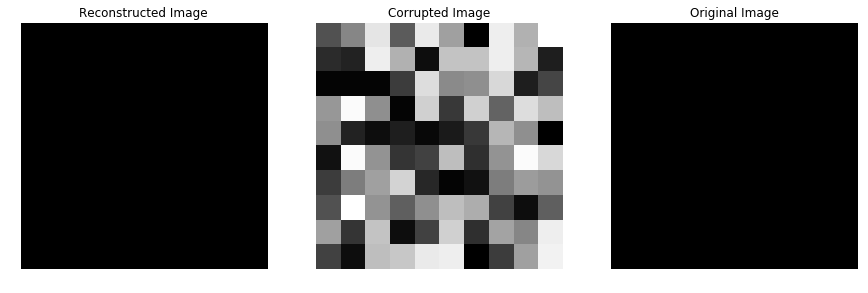

In [267]:
reconstruct_img_dp = Image.fromarray(np.uint8(beta_dp_graph))

%matplotlib inline
fig, ax = plt.subplots(1, 3,figsize=(15, 10))
print ax
ax[0].imshow(np.asarray(reconstruct_img_dp),cmap='gray');
ax[0].set_title("Reconstructed Image")
ax[0].axis('off')
ax[1].imshow(np.asarray(corr_img),cmap='gray');
ax[1].set_title("Corrupted Image")
ax[1].axis('off');
ax[2].imshow(np.asarray(orig_img),cmap='gray');
ax[2].set_title("Original Image")
ax[2].axis('off');

In [1]:
%%bash
ipython nbconvert --to latex --template citations.tplx Project.ipynb
pdflatex Project.tex
bibtex Project
pdflatex Project.tex
pdflatex Project.tex
pdflatex Project.tex

Couldn't find program: u'bash'
